In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf

#from utils.data_utils import img_to_array, array_to_img
from transformer import spatial_transformer_network as stn
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/home/pt/test1/ELM/data", one_hot=True)


Extracting /home/pt/test1/ELM/data/train-images-idx3-ubyte.gz
Extracting /home/pt/test1/ELM/data/train-labels-idx1-ubyte.gz
Extracting /home/pt/test1/ELM/data/t10k-images-idx3-ubyte.gz
Extracting /home/pt/test1/ELM/data/t10k-labels-idx1-ubyte.gz


In [2]:
input_img.shape

NameError: name 'input_img' is not defined

In [5]:
batch=128
out_H = 28
out_W = 28
out_dims = (out_H, out_W)
B, H, W, C = batch,28,28,1
#angleDeg = 10
#angleRad = angleDeg * np.pi / 180
#theta = np.array([[np.cos(angleRad), -np.sin(angleRad), 0], [np.sin(angleRad), np.cos(angleRad), 0]])

theta = np.array([[1., 0, 0], [0, 1., 0]])
theta2 = np.array([[1., 0, 0], [0, 1., 0]])
#theta2 = np.array([[0., 1, 0], [1, 0., 0]])
x = tf.placeholder(tf.float32, [None, H, W, C])

# create localisation network and convolutional layer
with tf.variable_scope('spatial_transformer_0'):

    # create a fully-connected layer with 6 output nodes
    n_fc = 6
    W_fc1 = tf.Variable(tf.zeros([H*W*C, n_fc]), name='W_fc1')

    # affine transformation
    theta = theta.astype('float32')
    theta = theta.flatten()

    b_fc1 = tf.Variable(initial_value=theta, name='b_fc1')
    h_fc1 = tf.matmul(tf.zeros([B, H*W*C]), W_fc1) + b_fc1
    h_trans = stn(x, h_fc1, out_dims)
    
with tf.variable_scope('spatial_transformer_02'):

    # create a fully-connected layer with 6 output nodes
    n_fc2 = 6
    W_fc12 = tf.Variable(tf.zeros([H*W*C, n_fc]), name='W_fc12')

    # affine transformation
    theta2 = theta2.astype('float32')
    theta2 = theta2.flatten()

    b_fc12 = tf.Variable(initial_value=theta2, name='b_fc12')
    h_fc12 = tf.matmul(tf.zeros([B, H*W*C]), W_fc12) + b_fc12
    h_trans2 = stn(h_trans, h_fc12, out_dims)
    
# run session
sess = tf.Session()
sess.run(tf.global_variables_initializer())
batch_x, _ = mnist.train.next_batch(batch)
input_img = np.reshape(batch_x, [-1,28, 28, 1])
y = sess.run(h_trans2, feed_dict={x: input_img})
print(y.shape)
y = np.reshape(y, (128,784))


(128, 28, 28, 1)


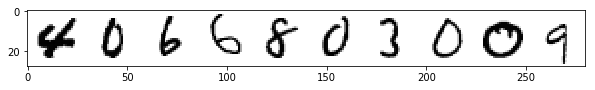

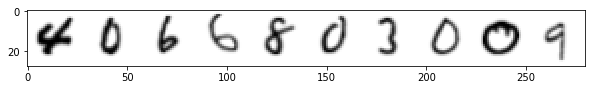

In [6]:
import matplotlib.pyplot as plt
n=10
canvas_orig1 = np.empty((28 * 1, 28 * n))

for i in range(1):
    # MNIST test set8
    g = (batch_x  + 1.) / 2.
    # Reverse colours for better display
    g = -1 * (g - 1)
    #g=np.dot(batch_x, np.transpose(net.beta)) 
    #g=np.dot(net2input,net.beta)
    # Display original images
    for j in range(n):
        # Draw the generated digits
        canvas_orig1[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] =g [j].reshape([28, 28])
        
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig1, origin="upper", cmap="gray")
plt.show()

n=10
canvas_orig = np.empty((28 * 1, 28 * n))

for i in range(1):
    # MNIST test set8
    g = (y  + 1.) / 2.
    # Reverse colours for better display
    g = -1 * (g - 1)
    #g=np.dot(batch_x, np.transpose(net.beta)) 
    #g=np.dot(net2input,net.beta)
    # Display original images
    for j in range(n):
        # Draw the generated digits
        canvas_orig[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] =g [j].reshape([28, 28])
        
plt.figure(figsize=(n, n))
plt.imshow(canvas_orig, origin="upper", cmap="gray")
plt.show()



In [5]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
# Parameters
learning_rate = 0.001
num_steps = 30000
batch_size = 64

# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 512
latent_dim = 20

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

# Building the encoder

out_H = 28
out_W = 28
out_dims = (out_H, out_W)
B, H, W, C = batch_size,28,28,1
angleDeg = 45
angleRad = angleDeg * np.pi / 180
theta = np.array([[np.cos(angleRad), -np.sin(angleRad), 0], [np.sin(angleRad), np.cos(angleRad), 0]])

#theta = np.array([[1., 0, 0], [0, 1., 0]])

x = tf.placeholder(tf.float32, [None, H, W, C])

# create localisation network and convolutional layer
with tf.variable_scope('spatial_transformer_0'):

    # create a fully-connected layer with 6 output nodes
    n_fc = 6
    W_fc1 = tf.Variable(tf.zeros([H*W*C, n_fc]), name='W_fc1')

    # affine transformation
    theta = theta.astype('float32')
    theta = theta.flatten()

    b_fc1 = tf.Variable(initial_value=theta, name='b_fc1')
    h_fc1 = tf.matmul(tf.zeros([B, H*W*C]), W_fc1) + b_fc1
    h_trans = stn(x, h_fc1, out_dims)
    
input_image=tf.reshape(h_trans, (batch_size,784))    
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
   
    input_img = np.reshape(batch_x, [-1,28, 28, 1])
    # Train
    feed_dict = {x: input_img}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i, l))

Step 1, Loss: 647.381958


KeyboardInterrupt: 

In [19]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
# Parameters
learning_rate = 0.001
num_steps = 30000
batch_size = 64

# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 512
latent_dim = 20

# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

# Building the encoder

out_H = 28
out_W = 28
out_dims = (out_H, out_W)
B, H, W, C = batch_size,28,28,1

theta = np.array([[1., 0, 0], [0, 1., 0]])

x = tf.placeholder(tf.float32, [None, H, W, C])

# create localisation network and convolutional layer
with tf.variable_scope('spatial_transformer_0'):

    # create a fully-connected layer with 6 output nodes
    n_fc = 6
    W_fc1 = tf.Variable(tf.zeros([H*W*C, n_fc]), name='W_fc1')

    # affine transformation
    theta = theta.astype('float32')
    theta = theta.flatten()

    b_fc1 = tf.Variable(initial_value=theta, name='b_fc1')
    h_fc1 = tf.matmul(tf.zeros([B, H*W*C]), W_fc1) + b_fc1
    h_trans = stn(x, h_fc1, out_dims)
    
input_image=tf.reshape(h_trans, (batch_size,784))    
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

decoder = tf.reshape(h_trans, (batch_size,H, W, C)) 

with tf.variable_scope('spatial_transformer_02'):

    # create a fully-connected layer with 6 output nodes
    n_fc2 = 6
    W_fc12 = tf.Variable(tf.zeros([H*W*C, n_fc]), name='W_fc12')

    # affine transformation
    theta = theta.astype('float32')
    theta = theta.flatten()

    b_fc12 = tf.Variable(initial_value=theta, name='b_fc12')
    h_fc12 = tf.matmul(tf.zeros([B, H*W*C]), W_fc12) + b_fc12
    decoder = stn(decoder, h_fc12, out_dims)
    
decoder = tf.reshape(decoder, (batch_size,784))    
# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start Training
# Start a new TF session
sess = tf.Session()

# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
   
    input_img = np.reshape(batch_x, [-1,28, 28, 1])
    # Train
    feed_dict = {x: input_img}
    _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0 or i == 1:
        print('Step %i, Loss: %f' % (i, l))

Step 1, Loss: 843.635559
Step 1000, Loss: nan


KeyboardInterrupt: 

In [46]:

# Testing
# Generate images from noise, using the generator network.
def sample_z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

n = 6
noise_dim=20
canvas = np.empty((28 * n, 28 * n))
for i in range(n):
    # Noise input.
    z_mu = np.random.uniform(-1., 1., size=[n, noise_dim])
    # Generate image from noise.
    #decoder = np.dot(z, net4.beta) 
    #decoder= np.dot(decoder, net3.beta) 
    #decoder= np.dot(decoder, net2.beta) 
    g = sess.run(decoder, feed_dict={noise_input: z_mu})
    #g= np.dot(z, net.beta) 
    # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
    g = (g + 1.) / 2.
    # Reverse colours for better display
    g = -1 * (g - 1)
    for j in range(n):
        # Draw the generated digits
        canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

plt.figure(figsize=(n, n))
plt.imshow(canvas, origin="upper", cmap="gray")
plt.show()

ValueError: Cannot feed value of shape (64, 2) for Tensor 'Placeholder_24:0', which has shape '(?, 20)'